In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import sklearn
import random
import sys
import os
import matplotlib.pyplot as plt
import math
from fractions import gcd
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [3]:
# ENABLE/DISABLE GPU
# UNCOMMENT to.device() FOR TENSORS AND NEURAL NETWORKS TO ENABLE GPU

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
np.set_printoptions(threshold=sys.maxsize, precision=2, suppress=True)

In [71]:
dataset = pd.read_csv('breast/breast.csv')
dataset

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [140]:
# NARROW THE FEATURES
array = np.array(['radius_mean', 'perimeter_mean', 'area_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'texture_mean',
                    'texture_worst'])
processed_data = dataset[array]
processed_data

,radius_mean,perimeter_mean,area_mean,radius_worst,perimeter_worst,area_worst,texture_mean,texture_worst
0,17.99,122.80,1001.0,25.380,184.60,2019.0,10.38,17.33
1,20.57,132.90,1326.0,24.990,158.80,1956.0,17.77,23.41
2,19.69,130.00,1203.0,23.570,152.50,1709.0,21.25,25.53
3,11.42,77.58,386.1,14.910,98.87,567.7,20.38,26.50
4,20.29,135.10,1297.0,22.540,152.20,1575.0,14.34,16.67
...,...,...,...,...,...,...,...,...
564,21.56,142.00,1479.0,25.450,166.10,2027.0,22.39,26.40
565,20.13,131.20,1261.0,23.690,155.00,1731.0,28.25,38.25
566,16.60,108.30,858.1,18.980,126.70,1124.0,28.08,34.12
567,20.60,140.10,1265.0,25.740,184.60,1821.0,29.33,39.42


In [141]:
# CONVERT TO NUMPY
numpy_data = processed_data.to_numpy()
numpy_data[0]

array([  17.99,  122.8 , 1001.  ,   25.38,  184.6 , 2019.  ,   10.38,
         17.33])

In [142]:
# NORMALIZE THE DATA
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(numpy_data)

In [143]:
scaled_data

     [0.3213, 0.3059, 0.1863, 0.2398, 0.2179, 0.117 , 0.1204, 0.1309],
       [0.186 , 0.1752, 0.0934, 0.1224, 0.1096, 0.0509, 0.0893, 0.0746],
       [0.2262, 0.2157, 0.122 , 0.1932, 0.1728, 0.0905, 0.2851, 0.303 ],
       [0.3445, 0.3278, 0.2077, 0.2949, 0.2759, 0.1559, 0.2861, 0.3529],
       [0.167 , 0.1594, 0.0809, 0.1067, 0.0981, 0.0436, 0.4525, 0.3252],
       [0.5939, 0.5923, 0.4554, 0.6403, 0.6011, 0.4591, 0.3108, 0.379 ],
       [0.2593, 0.2532, 0.139 , 0.1967, 0.1879, 0.09  , 0.3443, 0.2945],
       [0.6204, 0.6282, 0.4681, 0.5603, 0.5398, 0.3713, 0.4785, 0.464 ],
       [0.1661, 0.1594, 0.0809, 0.1113, 0.1013, 0.0467, 0.301 , 0.3337],
       [0.212 , 0.2059, 0.1101, 0.169 , 0.1608, 0.0749, 0.2858, 0.2556],
       [0.2186, 0.2104, 0.1161, 0.1604, 0.1543, 0.0716, 0.4998, 0.5224],
       [0.2943, 0.2783, 0.167 , 0.2305, 0.2071, 0.111 , 0.2066, 0.2247],
       [0.0956, 0.0869, 0.0436, 0.0629, 0.0522, 0.0247, 0.1586, 0.2146],
       [0.3085, 0.2895, 0.1793, 0.2504, 0.2245, 0.126

In [144]:
# SPLIT INTO TRAIN/TEST SETS (0.8 / 0.2)

trainset = scaled_data[:455, :]
testset = scaled_data[455:, :]
trainset

     [0.6678, 0.6835, 0.4952, 0.667 , 0.628 , 0.4679, 0.5702, 0.572 ],
       [0.4127, 0.3967, 0.2643, 0.4333, 0.3929, 0.2664, 0.3585, 0.5544],
       [0.2096, 0.2055, 0.1097, 0.158 , 0.143 , 0.0693, 0.1762, 0.1514],
       [0.3928, 0.381 , 0.2406, 0.3511, 0.3157, 0.1936, 0.4295, 0.4267],
       [0.1467, 0.138 , 0.0738, 0.1402, 0.1244, 0.0619, 0.1826, 0.2441],
       [0.5362, 0.517 , 0.3807, 0.476 , 0.4422, 0.301 , 0.3   , 0.3822],
       [0.2238, 0.2135, 0.1174, 0.1807, 0.1694, 0.0827, 0.253 , 0.2497],
       [0.2285, 0.2175, 0.1211, 0.1651, 0.1452, 0.0748, 0.2597, 0.3854],
       [0.2517, 0.2421, 0.1358, 0.1928, 0.1805, 0.0888, 0.2093, 0.2018],
       [0.3426, 0.3495, 0.1978, 0.2778, 0.2788, 0.1419, 0.4535, 0.6706],
       [0.274 , 0.2642, 0.1544, 0.207 , 0.1924, 0.0969, 0.3957, 0.306 ],
       [0.1296, 0.1171, 0.0613, 0.0725, 0.059 , 0.0291, 0.2878, 0.2348],
       [0.2536, 0.2582, 0.1416, 0.2746, 0.2554, 0.1435, 0.58  , 0.7281],
       [0.3729, 0.3912, 0.2239, 0.2899, 0.3396, 0.147

In [145]:
# SET THE PORTION OF MISSING VALUES
REPLACE_COUNT = trainset.size*0.05
NAN = 10000000

missing_data_train = trainset
full_data_train = missing_data_train.copy()

# REPLACE RANDOM VALUES WITH NAN IN TRAINSET
replaced_index = np.random.choice(missing_data_train.size, int(REPLACE_COUNT), replace=False)
for index in replaced_index:
    missing_data_train.flat[index] = NAN


missing_data_test = testset
full_data_test = missing_data_test.copy()

#REPLACE RANDOM VALUES WITH NAN IN TESTSET
replaced_index2 = np.random.choice(missing_data_test.size, int(REPLACE_COUNT*0.2), replace=False)
for index in replaced_index2:
    missing_data_test.flat[index] = NAN

In [146]:
missing_data_train[0]

array([0.521 , 0.546 , 0.3637, 0.6208, 0.6683, 0.4507, 0.0227, 0.1415])

In [147]:
full_data_train[0]

array([0.521 , 0.546 , 0.3637, 0.6208, 0.6683, 0.4507, 0.0227, 0.1415])

In [230]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=8, out_features=4)
        self.enc2 = nn.Linear(in_features=4, out_features=2)

        self.dec2 = nn.Linear(in_features=2, out_features=4)
        self.dec3 = nn.Linear(in_features=4, out_features=8)

    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        x = F.leaky_relu(self.dec2(x))
        x = self.dec3(x)
        return x

In [231]:
# CREATE A SEED FOR CONSISTENT WEIGHT INITIALIZATIONS - FOR TESTING PURPOSES
random.seed(1)
torch.manual_seed(random.randint(1, 10))
net = Autoencoder().double()
#net.to(device)

In [232]:
NUM_EPOCHS = 250
LEARNING_RATE = 0.0001
BATCH_SIZE = -1
NUM_FEATURES = 8
BATCH_SIZE_TEST = -1

In [233]:
x_train = torch.from_numpy(missing_data_train)
#x_train = x_train.to(device)
x_train = x_train.view(BATCH_SIZE, NUM_FEATURES)

y_train = torch.from_numpy(full_data_train)
#y_train = y_train.to(device)
y_train = y_train.view(BATCH_SIZE, NUM_FEATURES)

x_test = torch.from_numpy(missing_data_test)
#x_test = x_test.to(device)
x_test = x_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

y_test = torch.from_numpy(full_data_test)
#y_test = y_test.to(device)
y_test = y_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

x_train.shape

torch.Size([455, 8])

In [234]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [236]:
def train(net):
    train_loss = []
    torch.set_printoptions(precision=2, sci_mode=False)

    for epoch in range(NUM_EPOCHS):
        # running_loss: LOSS OF THE PREDICTED MISSING VALUE ONLY
        # overall_loss: LOSS OF ALL RECONSTRUCTED VALUES

        running_loss = 0.0
        overall_loss = 0.0
        count = 0
        for missing_data, full_data in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
            
            # COMPUTE LOSS OF PREDICTED MISSING VALUE
            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            # PRINT ALL VALUES ON LAST EPOCH FOR TESTING PURPOSES
            if epoch == NUM_EPOCHS-1:
                np.set_printoptions(precision=2, suppress=True)
                print("Input: ", scaler.inverse_transform(missing_data.reshape(-1,8)))
                print("Target: ", scaler.inverse_transform(full_data.reshape(-1,8)))
                print("Outputs: ", scaler.inverse_transform(outputs.reshape(-1,8).detach().numpy()))
        
        loss = running_loss / count
        overall_loss = overall_loss / len(x_train)
        train_loss.append(loss)

        print('Epoch {} of {}, Train Loss: {:.3f}, Overall: {:.3f}'
            .format(epoch+1, NUM_EPOCHS, loss, overall_loss))

    return train_loss


def test(net):

    net.eval()
    count = 0

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0

        for missing_data, full_data in zip(x_test, y_test):
            outputs = net(missing_data.double())
            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            print("Input: ", scaler.inverse_transform(missing_data.reshape(-1,8)))
            print("Target: ", scaler.inverse_transform(full_data.reshape(-1,8)))
            print("Outputs: ", scaler.inverse_transform(outputs.reshape(-1,8).detach().numpy()))

        loss = running_loss / count
        test_loss.append(loss)
        print('Test Loss: {:.3f}'.format(loss))

        return test_loss

In [237]:
# TRAIN THE NEURAL NETWORK
results = train(net)

.82 579.7   18.84  25.99]]
Outputs:  [[ 14.31  93.15 673.34  16.57 109.42 912.38  18.95  25.35]]
Input:  [[  16.5   106.6   838.1    18.13  117.2  1009.     18.29   25.45]]
Target:  [[  16.5   106.6   838.1    18.13  117.2  1009.     18.29   25.45]]
Outputs:  [[ 14.31  93.15 673.26  16.57 109.41 912.33  18.95  25.35]]
Input:  [[1.34e+01 8.55e+01 5.52e+02 1.47e+01 9.38e+01 6.64e+02 2.96e+08 2.17e+01]]
Target:  [[ 13.4   85.48 552.4   14.73  93.76 663.5   16.95  21.7 ]]
Outputs:  [[ 15.06 101.5  740.29  16.71 108.58 976.14  19.98  26.44]]
Input:  [[  20.44  133.8  1293.     24.31  161.2  1780.     21.78   26.37]]
Target:  [[  20.44  133.8  1293.     24.31  161.2  1780.     21.78   26.37]]
Outputs:  [[ 14.31  93.14 673.12  16.57 109.39 912.23  18.95  25.35]]
Input:  [[2.02e+01 1.45e+09 1.23e+03 2.42e+01 1.60e+02 1.67e+03 2.68e+01 3.38e+01]]
Target:  [[  20.2   133.7  1234.     24.19  160.   1671.     26.83   33.81]]
Outputs:  [[ 14.62  98.91 693.43  16.41 105.63 960.65  19.66  25.98]]
Inp

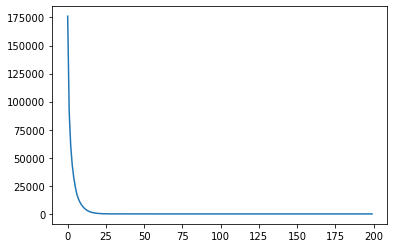

In [210]:
plt.plot(results)

In [211]:
# TEST THE NEURAL NETWORK
test_result = test(net)

15.73  19.35]]
Outputs:  [[ 14.18  92.46 664.19  16.44 108.22 891.83  18.9   25.3 ]]
Input:  [[1.42e+01 9.24e+01 6.18e+02 1.64e+01 1.12e+02 4.07e+10 2.05e+01 2.73e+01]]
Target:  [[ 14.2   92.41 618.4   16.45 112.1  828.5   20.53  27.26]]
Outputs:  [[ 14.14  92.72 659.02  16.44 107.93 889.83  18.84  25.69]]
Input:  [[1.39e+01 1.45e+09 5.99e+02 1.51e+01 1.01e+02 7.19e+02 1.66e+01 2.18e+01]]
Target:  [[ 13.9   88.97 599.4   15.14 101.2  718.9   16.62  21.8 ]]
Outputs:  [[ 14.21  92.48 662.03  16.41 108.14 892.42  18.95  25.33]]
Input:  [[1.15e+01 7.40e+01 4.05e+02 1.24e+01 8.20e+01 4.07e+10 1.46e+01 2.19e+01]]
Target:  [[ 11.49  73.99 404.9   12.4   82.04 467.6   14.59  21.9 ]]
Outputs:  [[ 14.14  92.72 659.02  16.44 107.93 889.83  18.84  25.69]]
Input:  [[ 16.25 109.8  815.8   17.39 122.1  939.7   19.51  23.05]]
Target:  [[ 16.25 109.8  815.8   17.39 122.1  939.7   19.51  23.05]]
Outputs:  [[ 14.18  92.46 664.19  16.44 108.22 891.83  18.9   25.3 ]]
Input:  [[ 12.16  78.29 455.3   13.34  

In [123]:
torch.save(net, './breast_autoencoder3')

# The following section is for reconstructing a brand new dataset from an input dataset that has missing values.
# This new dataset can be used in some classifiers to see if the accuracy changes.

In [124]:
dataset = pd.read_csv('breast/breast.csv')
array = np.array(['radius_mean', 'perimeter_mean', 'area_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'texture_mean',
                    'texture_worst'])
filtered_data = dataset[array]
filtered_data

,radius_mean,perimeter_mean,area_mean,radius_worst,perimeter_worst,area_worst,texture_mean,texture_worst
0,17.99,122.80,1001.0,25.380,184.60,2019.0,10.38,17.33
1,20.57,132.90,1326.0,24.990,158.80,1956.0,17.77,23.41
2,19.69,130.00,1203.0,23.570,152.50,1709.0,21.25,25.53
3,11.42,77.58,386.1,14.910,98.87,567.7,20.38,26.50
4,20.29,135.10,1297.0,22.540,152.20,1575.0,14.34,16.67
...,...,...,...,...,...,...,...,...
564,21.56,142.00,1479.0,25.450,166.10,2027.0,22.39,26.40
565,20.13,131.20,1261.0,23.690,155.00,1731.0,28.25,38.25
566,16.60,108.30,858.1,18.980,126.70,1124.0,28.08,34.12
567,20.60,140.10,1265.0,25.740,184.60,1821.0,29.33,39.42


In [125]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

np.set_printoptions(precision=4, suppress=True)
scaled_set = scaler.fit_transform(filtered_data.to_numpy())
scaled_set

     [0.3213, 0.3059, 0.1863, 0.2398, 0.2179, 0.117 , 0.1204, 0.1309],
       [0.186 , 0.1752, 0.0934, 0.1224, 0.1096, 0.0509, 0.0893, 0.0746],
       [0.2262, 0.2157, 0.122 , 0.1932, 0.1728, 0.0905, 0.2851, 0.303 ],
       [0.3445, 0.3278, 0.2077, 0.2949, 0.2759, 0.1559, 0.2861, 0.3529],
       [0.167 , 0.1594, 0.0809, 0.1067, 0.0981, 0.0436, 0.4525, 0.3252],
       [0.5939, 0.5923, 0.4554, 0.6403, 0.6011, 0.4591, 0.3108, 0.379 ],
       [0.2593, 0.2532, 0.139 , 0.1967, 0.1879, 0.09  , 0.3443, 0.2945],
       [0.6204, 0.6282, 0.4681, 0.5603, 0.5398, 0.3713, 0.4785, 0.464 ],
       [0.1661, 0.1594, 0.0809, 0.1113, 0.1013, 0.0467, 0.301 , 0.3337],
       [0.212 , 0.2059, 0.1101, 0.169 , 0.1608, 0.0749, 0.2858, 0.2556],
       [0.2186, 0.2104, 0.1161, 0.1604, 0.1543, 0.0716, 0.4998, 0.5224],
       [0.2943, 0.2783, 0.167 , 0.2305, 0.2071, 0.111 , 0.2066, 0.2247],
       [0.0956, 0.0869, 0.0436, 0.0629, 0.0522, 0.0247, 0.1586, 0.2146],
       [0.3085, 0.2895, 0.1793, 0.2504, 0.2245, 0.126

In [126]:
REPLACE_COUNT = scaled_set.size*0.1               # Set the number of missing values
NAN = 1000000

missing_data = scaled_data

replaced_index = np.random.choice(missing_data.size, int(REPLACE_COUNT), replace=False)

for index in replaced_index:
    missing_data.flat[index] = NAN

input_tensor = torch.from_numpy(missing_data)
input_tensor = input_tensor.view(input_tensor.shape[0], NUM_FEATURES)


In [127]:
input_tensor

tensor([[    0.521,     0.546,     0.364,  ...,     0.451,     0.023,
             0.142],
        [    0.643,     0.616, 1000000.000,  ...,     0.435,     0.273,
         1000000.000],
        [    0.601,     0.596,     0.449,  ...,     0.375,     0.390,
             0.360],
        ...,
        [    0.455, 1000000.000, 1000000.000,  ..., 1000000.000,     0.621,
             0.589],
        [    0.645,     0.666,     0.476,  ...,     0.402, 1000000.000,
             0.730],
        [    0.037,     0.029,     0.016,  ...,     0.020,     0.502,
         1000000.000]], dtype=torch.float64)

In [128]:
my_model = torch.load('breast_autoencoder3')
my_model

Autoencoder(
  (enc1): Linear(in_features=8, out_features=4, bias=True)
  (enc2): Linear(in_features=4, out_features=2, bias=True)
  (dec2): Linear(in_features=2, out_features=4, bias=True)
  (dec3): Linear(in_features=4, out_features=8, bias=True)
)

In [129]:
new_dataset = my_model(input_tensor.double())
torch.set_printoptions(precision=4, sci_mode=False)
new_dataset

tensor([[ 0.3799,  0.3027,  0.1006,  ...,  0.1167,  0.2394,  0.5158],
        [ 0.4207,  0.5192,  0.6638,  ...,  0.6272,  0.1642,  0.1092],
        [ 0.3799,  0.3027,  0.1006,  ...,  0.1166,  0.2394,  0.5158],
        ...,
        [ 0.4082,  0.4517,  0.4513,  ...,  0.5579,  0.1604,  0.4503],
        [ 0.3248,  0.3356,  0.2771,  ...,  0.4296,  0.2480,  0.5922],
        [-0.0208, -0.1500, -0.0429,  ...,  0.0524,  0.5287,  0.3562]],
       dtype=torch.float64, grad_fn=<AddmmBackward>)

In [130]:
new_dataset = scaler.inverse_transform(new_dataset.detach().numpy())
new_dataset

      [   15.0052,    87.4484,   377.0043,    16.9649,   114.769 ,
          646.2469,    16.8037,    31.2865],
       [   14.7073,   100.2051,   974.9795,    10.8986,    83.3944,
         2178.2199,    15.7478,    32.2582],
       [    6.0128,    12.8392,  -335.7506,    20.1826,   124.0043,
          123.7739,    25.8306,    33.9462],
       [    6.4637,    21.1327,    11.3429,    19.0821,   112.7144,
          369.5214,    25.4429,    25.9762],
       [    1.8116,    -6.7315,   -71.6742,    25.3771,   162.2615,
         -545.1551,    33.4259,    12.6959],
       [   14.0632,    93.9862,   820.3815,    11.9772,    92.9934,
         1985.2609,    16.6902,    34.3265],
       [   14.9974,    87.097 ,   368.6368,    17.0847,   115.1497,
          614.509 ,    16.8384,    31.0856],
       [   14.0502,    93.9118,   820.3664,    11.9945,    93.1279,
         1982.8015,    16.7128,    34.2834],
       [    6.5407,    22.0836,    42.407 ,    18.935 ,   111.3263,
          398.4152,    25.344

In [131]:
np.savetxt('new_breast.csv', new_dataset)